In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, recall_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import warnings
import zipfile

warnings.filterwarnings('ignore')

%matplotlib inline

# Set random seeds for reproducibility
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
zip_file_path = '../data/transaction_data.csv.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    csv_file_name = 'transaction_data.csv'  
    zip_ref.extract(csv_file_name, path='../data/extracted/')

df = pd.read_csv('../data/extracted/transaction_data.csv')

if "Unnamed: 0" in df.columns:
    df.drop("Unnamed: 0", axis=1, inplace=True)

df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0


In [4]:
fraud = df[df['Class'] == 1]

fraud

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.353229,1
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758,1
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.606031,1
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,-0.117342,1
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.349231,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1.206024,1
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,-0.350191,1
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,-0.041818,1
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,0.626302,1


In [5]:
X_train_df, X_test_df = train_test_split(df, test_size=0.25, random_state=42)

X_train_vae_df, X_test_vae_df = X_train_df.copy(), X_test_df.copy()

# Only train on legitimate transactions for the VAE
X_train_vae_df = X_train_vae_df[X_train_vae_df['Class'] == 0]
y_test_vae = X_test_vae_df['Class']

X_train_vae_df = X_train_vae_df.drop(['Class'], axis=1)
X_test_vae_df = X_test_vae_df.drop(['Class'], axis=1)

scaler = StandardScaler()
X_train_vae_np = scaler.fit_transform(X_train_vae_df)
X_test_vae_np = scaler.transform(X_test_vae_df)

X_train_vae = torch.tensor(X_train_vae_np, dtype=torch.float).to(device)
X_test_vae = torch.tensor(X_test_vae_np, dtype=torch.float).to(device)

# Ensure data does not contain NaNs or Infs to ensure gradient stability
assert not torch.isnan(X_train_vae).any(), "NaN values in X_train_vae"
assert not torch.isinf(X_train_vae).any(), "Inf values in X_train_vae"

input_dim_vae = X_train_vae.shape[1]

# Create DataLoader for mini-batch training
batch_size = 128
train_vae_dataset = TensorDataset(X_train_vae)
train_vae_loader = DataLoader(train_vae_dataset, batch_size=batch_size, shuffle=True)

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_1_dim, hidden_2_dim, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_1_dim)
        self.fc2 = nn.Linear(hidden_1_dim, hidden_2_dim)
        self.fc_mu = nn.Linear(hidden_2_dim, z_dim)
        self.fc_logvar = nn.Linear(hidden_2_dim, z_dim)

    def forward(self, x):
        x1 = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        h = F.leaky_relu(self.fc2(x1), negative_slope=0.01)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_1_dim, hidden_2_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_1_dim)
        self.fc2 = nn.Linear(hidden_1_dim, hidden_2_dim)
        self.fc_out = nn.Linear(hidden_2_dim, output_dim)
        self.fc_logvar = nn.Linear(hidden_2_dim, output_dim)

    def forward(self, z):
        x1 = F.leaky_relu(self.fc1(z), negative_slope=0.01)
        h = F.leaky_relu(self.fc2(x1), negative_slope=0.01)
        x_mu = self.fc_out(h)
        x_logvar = self.fc_logvar(h)
        return x_mu, x_logvar

# Reparameterization trick
def reparameterize(mu, log_var):
    std = torch.exp(0.5 * log_var) + 1e-7
    eps = torch.randn_like(std)
    return mu + eps * std

# In this experiment, we ignore the KL divergence and use MSE loss as our sole objective.
criterion = nn.MSELoss()

Epoch 1/50, MSE Loss: 0.9186
Epoch 2/50, MSE Loss: 0.8560
Epoch 3/50, MSE Loss: 0.8246
Epoch 4/50, MSE Loss: 0.8093
Epoch 5/50, MSE Loss: 0.8036
Epoch 6/50, MSE Loss: 0.7988
Epoch 7/50, MSE Loss: 0.7951
Epoch 8/50, MSE Loss: 0.7916
Epoch 9/50, MSE Loss: 0.7878
Epoch 10/50, MSE Loss: 0.7837
Epoch 11/50, MSE Loss: 0.7795
Epoch 12/50, MSE Loss: 0.7753
Epoch 13/50, MSE Loss: 0.7717
Epoch 14/50, MSE Loss: 0.7688
Epoch 15/50, MSE Loss: 0.7662
Epoch 16/50, MSE Loss: 0.7636
Epoch 17/50, MSE Loss: 0.7619
Epoch 18/50, MSE Loss: 0.7597
Epoch 19/50, MSE Loss: 0.7587
Epoch 20/50, MSE Loss: 0.7573
Epoch 21/50, MSE Loss: 0.7562
Epoch 22/50, MSE Loss: 0.7548
Epoch 23/50, MSE Loss: 0.7540
Epoch 24/50, MSE Loss: 0.7532
Epoch 25/50, MSE Loss: 0.7519
Epoch 26/50, MSE Loss: 0.7510
Epoch 27/50, MSE Loss: 0.7504
Epoch 28/50, MSE Loss: 0.7493
Epoch 29/50, MSE Loss: 0.7477
Epoch 30/50, MSE Loss: 0.7472
Epoch 31/50, MSE Loss: 0.7464
Epoch 32/50, MSE Loss: 0.7456
Epoch 33/50, MSE Loss: 0.7445
Epoch 34/50, MSE Lo

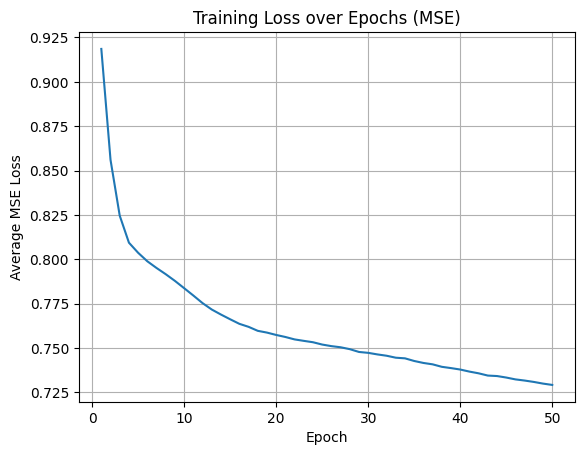

In [7]:
# Hyperparameters for this run
z_dim = 1
hidden_1_dim = 128
hidden_2_dim = 64
num_epochs = 50

# Instantiate models and optimizer
encoder = Encoder(input_dim_vae, hidden_1_dim, hidden_2_dim, z_dim).to(device)
decoder = Decoder(z_dim, hidden_2_dim, hidden_1_dim, input_dim_vae).to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

train_losses = []
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    epoch_loss = 0.0
    for batch in train_vae_loader:
        x_batch = batch[0].to(device)
        optimizer.zero_grad()
        
        # Forward pass through encoder
        mu, log_var = encoder(x_batch)
        # Reparameterization
        z = reparameterize(mu, log_var)
        # Decode
        x_mu, _ = decoder(z)  # We use only x_mu for reconstruction
        loss = criterion(x_mu, x_batch)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)
    
    avg_loss = epoch_loss / len(X_train_vae)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, MSE Loss: {avg_loss:.4f}")

plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
plt.title('Training Loss over Epochs (MSE)')
plt.grid()
plt.show()

In [ ]:
def compute_recon_error(x_batch, n_samples=1000):
    # Use the current encoder and decoder in evaluation mode
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        mu, log_var = encoder(x_batch)
        
        # Sample multiple latent vectors using reparameterization
        # We generate multiple samples per input and average the reconstruction error.
        errors = []
        for _ in range(n_samples):
            z = reparameterize(mu, log_var)
            x_mu, _ = decoder(z)
            error = torch.mean((x_mu - x_batch)**2, dim=1)  # MSE per sample
            errors.append(error)
        errors = torch.stack(errors, dim=0)
        recon_error_mean = torch.mean(errors, dim=0)
        return recon_error_mean.cpu().numpy()

Computing reconstruction errors for test set...
Processed 10/557 batches
Processed 20/557 batches
Processed 30/557 batches
Processed 40/557 batches
Processed 50/557 batches
Processed 60/557 batches
Processed 70/557 batches
Processed 80/557 batches
Processed 90/557 batches
Processed 100/557 batches
Processed 110/557 batches
Processed 120/557 batches
Processed 130/557 batches
Processed 140/557 batches
Processed 150/557 batches
Processed 160/557 batches
Processed 170/557 batches
Processed 180/557 batches
Processed 190/557 batches
Processed 200/557 batches
Processed 210/557 batches
Processed 220/557 batches
Processed 230/557 batches
Processed 240/557 batches
Processed 250/557 batches
Processed 260/557 batches
Processed 270/557 batches
Processed 280/557 batches
Processed 290/557 batches
Processed 300/557 batches
Processed 310/557 batches
Processed 320/557 batches
Processed 330/557 batches
Processed 340/557 batches
Processed 350/557 batches
Processed 360/557 batches
Processed 370/557 batches

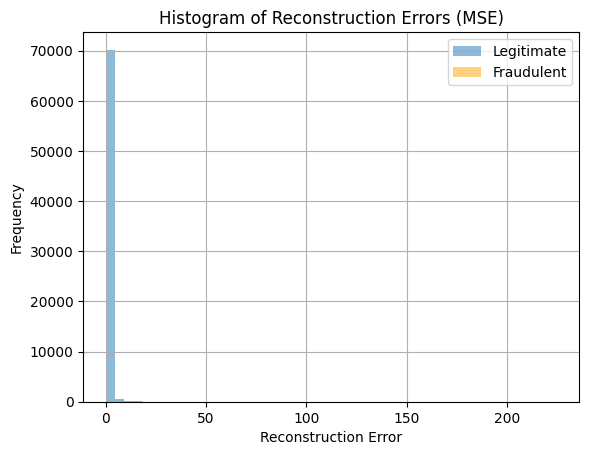

In [9]:
# Compute reconstruction errors on test set using mini-batches
test_batch_size = 128
test_vae_dataset = TensorDataset(X_test_vae)
test_vae_loader = DataLoader(test_vae_dataset, batch_size=test_batch_size, shuffle=False)

print("Computing reconstruction errors for test set...")
recon_errors = []
for batch_idx, batch in enumerate(test_vae_loader):
    x_batch = batch[0]
    errors = compute_recon_error(x_batch, n_samples=100)  # fewer samples for speed
    recon_errors.extend(errors)
    if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(test_vae_loader):
        print(f"Processed {batch_idx + 1}/{len(test_vae_loader)} batches")

error_df = pd.DataFrame({
    'reconstruction_error': recon_errors,
    'true_class': y_test_vae.values
})

# Plot histogram of reconstruction errors
plt.figure()
errors_legit = error_df[error_df['true_class'] == 0]['reconstruction_error']
errors_fraud = error_df[error_df['true_class'] == 1]['reconstruction_error']
plt.hist(errors_legit, bins=50, alpha=0.5, label='Legitimate')
plt.hist(errors_fraud, bins=50, alpha=0.5, label='Fraudulent', color='orange')
plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors (MSE)')
plt.grid()
plt.show()

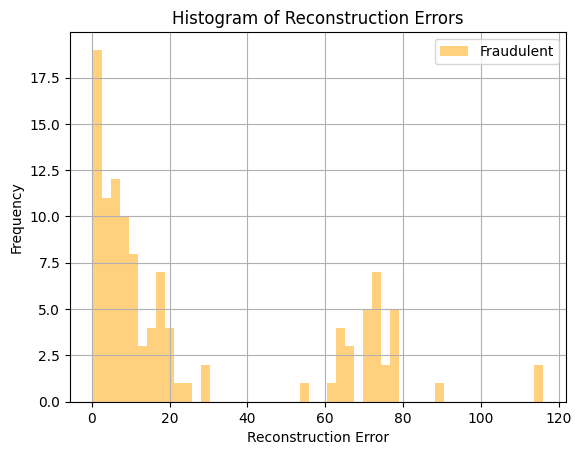

In [10]:
plt.hist(errors_fraud, bins=50, alpha=0.5, label='Fraudulent', color='orange')
plt.legend()
plt.grid()
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.show()


Optimal Threshold based on F-beta Score (β=30): 1.25
Precision at Optimal Threshold: 0.02
Recall at Optimal Threshold: 0.89
F-beta Score at Optimal Threshold: 0.85

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     71089
           1       0.02      0.89      0.04       113

    accuracy                           0.93     71202
   macro avg       0.51      0.91      0.50     71202
weighted avg       1.00      0.93      0.96     71202



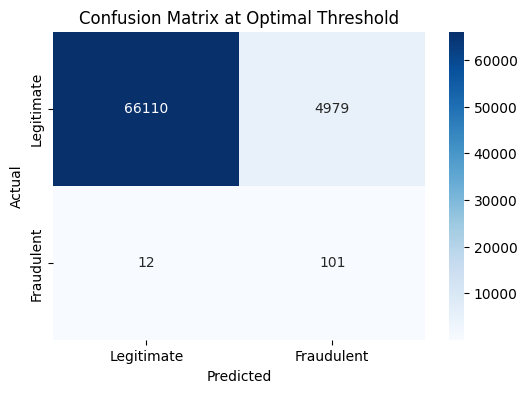

In [35]:
# Compute Precision-Recall curve and determine optimal threshold using F-Beta (β=30)
y_true = error_df['true_class'].values
y_scores = error_df['reconstruction_error'].values
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)

beta = 30
fbeta_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-8)
optimal_idx = np.argmax(fbeta_scores)
optimal_threshold = thresholds_pr[optimal_idx]
optimal_fbeta = fbeta_scores[optimal_idx]
optimal_precision = precision[optimal_idx]
optimal_recall = recall[optimal_idx]

print(f"\nOptimal Threshold based on F-beta Score (β={beta}): {optimal_threshold:.2f}")
print(f"Precision at Optimal Threshold: {optimal_precision:.2f}")
print(f"Recall at Optimal Threshold: {optimal_recall:.2f}")
print(f"F-beta Score at Optimal Threshold: {optimal_fbeta:.2f}")

error_df['predicted_class'] = (error_df['reconstruction_error'] >= optimal_threshold).astype(int)

cm = confusion_matrix(error_df['true_class'], error_df['predicted_class'])
print("\nClassification Report at Optimal Threshold:")
print(classification_report(error_df['true_class'], error_df['predicted_class']))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix at Optimal Threshold')
plt.show()

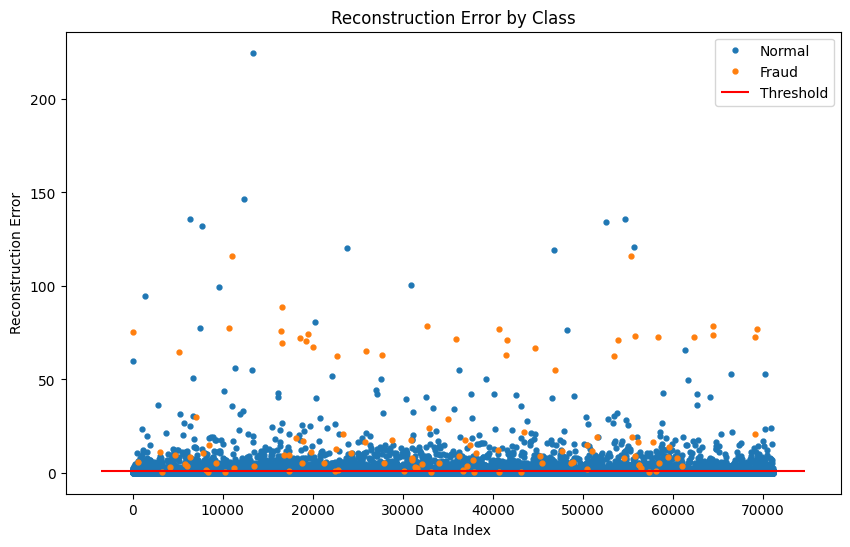

In [36]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(10,6))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', linestyle='',
            ms=3.5, label='Fraud' if name == 1 else 'Normal')
ax.hlines(optimal_threshold, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
          colors='r', zorder=100, label='Threshold')
ax.legend()
plt.title('Reconstruction Error by Class')
plt.xlabel('Data Index')
plt.ylabel('Reconstruction Error')
plt.show()

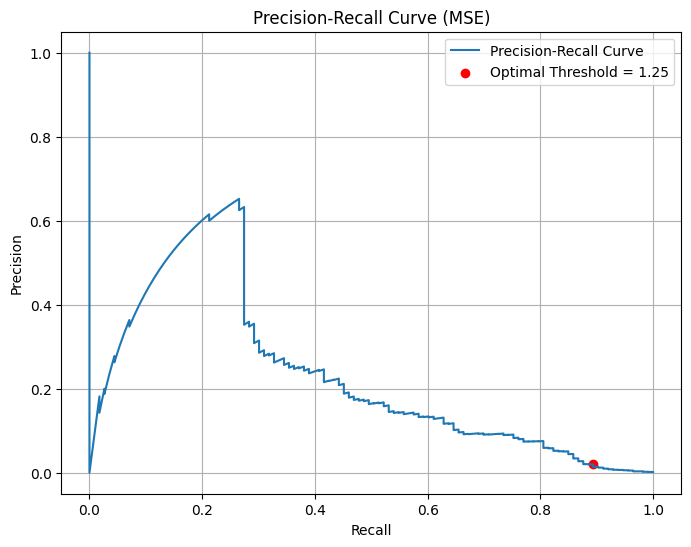

In [37]:
# Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
percentiles = [90, 95, 97.5, 99]
thresholds_percentiles = [np.percentile(y_scores[y_true == 0], q) for q in percentiles]

for perc, thresh in zip(percentiles, thresholds_percentiles):
    error_df['predicted_class'] = (error_df['reconstruction_error'] >= thresh).astype(int)
    cm = confusion_matrix(error_df['true_class'], error_df['predicted_class'])
    f1 = f1_score(y_true, error_df['predicted_class'])
    print(f"\nThreshold at {perc}th percentile: {thresh:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"F1 Score: {f1:.2f}")
    print(classification_report(y_true, error_df['predicted_class']))


Threshold at 90th percentile: 1.04
Confusion Matrix:
[[63980  7109]
 [   12   101]]
F1 Score: 0.03
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     71089
           1       0.01      0.89      0.03       113

    accuracy                           0.90     71202
   macro avg       0.51      0.90      0.49     71202
weighted avg       1.00      0.90      0.95     71202


Threshold at 95th percentile: 1.51
Confusion Matrix:
[[67534  3555]
 [   14    99]]
F1 Score: 0.05
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     71089
           1       0.03      0.88      0.05       113

    accuracy                           0.95     71202
   macro avg       0.51      0.91      0.51     71202
weighted avg       1.00      0.95      0.97     71202


Threshold at 97.5th percentile: 2.50
Confusion Matrix:
[[69311  1778]
 [   18    95]]
F1 Score: 0.10
              precision    recall  f1-score 

Threshold (95th percentile of legitimate errors): 1.04
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     71089
           1       0.01      0.89      0.03       113

    accuracy                           0.90     71202
   macro avg       0.51      0.90      0.49     71202
weighted avg       1.00      0.90      0.95     71202



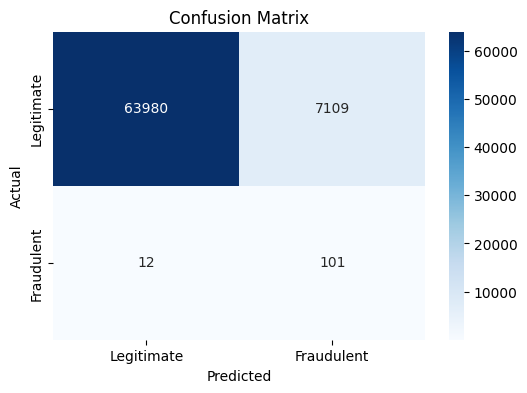

In [39]:
threshold = np.percentile(errors_legit, 90)
print(f"Threshold (95th percentile of legitimate errors): {threshold:.2f}")

error_df['predicted_class'] = error_df['reconstruction_error'].apply(lambda x: 1 if x >= threshold else 0)

cm = confusion_matrix(error_df['true_class'], error_df['predicted_class'])
print(classification_report(error_df['true_class'], error_df['predicted_class']))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

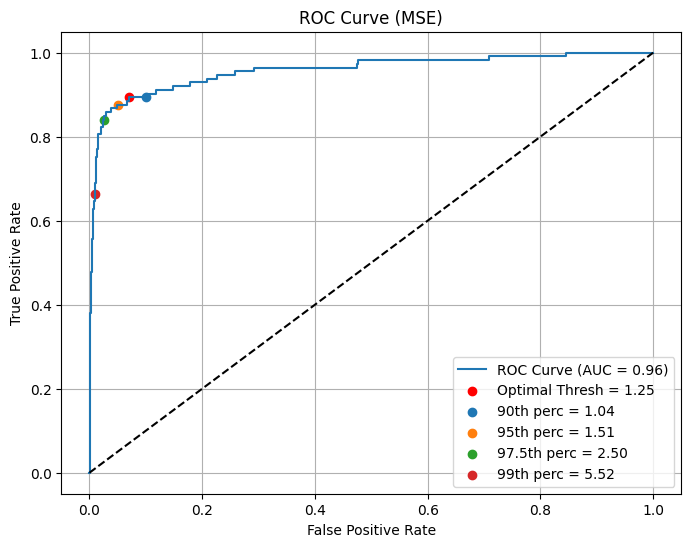

In [40]:
fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MSE)")
plt.legend()
plt.grid(True)

# Mark the optimal threshold on the ROC curve
def get_roc_point(threshold, y_true, y_scores):
    y_pred = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr_val = fp / (fp + tn) if (fp+tn) > 0 else 0
    tpr_val = tp / (tp + fn) if (tp+fn) > 0 else 0
    return fpr_val, tpr_val

opt_fpr, opt_tpr = get_roc_point(optimal_threshold, y_true, y_scores)
plt.scatter(opt_fpr, opt_tpr, color='red', label=f"Optimal Thresh = {optimal_threshold:.2f}")

# Mark the percentile thresholds based on legitimate errors
legit_errors = error_df[error_df['true_class'] == 0]['reconstruction_error']
percentiles = [90, 95, 97.5, 99]
perc_thresholds = [np.percentile(legit_errors, q) for q in percentiles]
for q, thresh in zip(percentiles, perc_thresholds):
    fpr_val, tpr_val = get_roc_point(thresh, y_true, y_scores)
    plt.scatter(fpr_val, tpr_val, label=f"{q}th perc = {thresh:.2f}")

plt.legend()
plt.show()